In [79]:
import numpy as np
import matplotlib.pyplot as plt

def get_reads_from(seq, read_len=200, coverage=5):
    L = len(seq)
    read_amt = int(L/read_len * coverage)
    reads = []
    for _ in range(read_amt):
        start = np.random.randint(0,L-read_len)
        read = seq[start:start+read_len]
        reads.append(read)
    return reads

def random_seq(length=250):
    indices = np.random.randint(0, 3, size=(length))
    chars = ["a", "c", "g", "t"]
    sequence = []
    for index in indices:
        sequence.append(chars[index])
    
    return sequence

def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq


def get_maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos-len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
        
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s])
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]




def correct_counts(maxed_counts, maxed_count_indices, target_sequence, start_end_posis, seqs, diff_profile, kmer_profile):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    # When corrections are necessary they are written into the maxed_counts array
    for i in range(1,len(maxed_count_indices)):
        # Make sure we have a change position on our hands.
        if maxed_counts[i] != maxed_counts[i-1]: 
            start_sum_at = last_correction
            end_sum_at = maxed_count_indices[i]+1
            
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
                
            last_correction = maxed_count_indices[i] + 1
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])

    return diff_profile, correction_artifact



def get_correction_profile(target, seqs, overlap_size, start_dict, end_dict):
    corr_profile = [0 for i in range(len(target)-overlap_size+1)]
    #corr_profile[0] = -1
    for i in range(len(target)-overlap_size):
        #
        #if i == 0:
            # Note that this whole check is necessary because our target sequence, i.e. the read we are investigating at the moment
            # also starts at the beginning and would thus be added to the count profile. We anticipate this by increasing the correction
            # profile at this point to one s.t. the loop below can reduce it to zero in the first step if just our sequence starts there.
            # If another sequence starts here, then the loop below will reduce the correction profile below zero
            #corr_profile[0] = 1
        start_snippet = ''.join(str(x) for x in target[i : i+overlap_size])      
        if start_snippet in start_dict:
            #print(target_snippet)
            #print(se_dict[target_snippet])
            corr_profile[i] -= start_dict[start_snippet]

    for i in range(overlap_size, len(target)+1):
        end_snippet = ''.join(str(x) for x in target[i-overlap_size : i])
        if end_snippet in end_dict:
            corr_profile[i-overlap_size+1] += end_dict[end_snippet]
    
        
    corr_profile[0]=0
    return corr_profile



def correct_diff_profile(filename, str_profile, seq_to_investigate, data=[]):
    seqs = []
    if data:
        for read in data:
            sequence_chars = [val for val in read]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    else:
        with open(filename) as file_in:
            for line in file_in:
                newline = line.rstrip('\n')
                sequence_chars = [char for char in newline]
                sequence = parse_nucleotides(sequence_chars)
                seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    starts = {}
    ends = {}
    seqs_kmers = {}
    for sequence in seqs:
        for i in range(len(sequence) - f):
            spaced_kmer = sequence[i:i+f] * profile
            spaced_kmer = spaced_kmer[spaced_kmer != 0]
            s = ''.join(str(x) for x in spaced_kmer)
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1

            if i == 0 or i == len(sequence)-f-1:
                solid_kmer = sequence[i:i+f]
                s2 = ''.join(str(x) for x in solid_kmer)
                addon = 0
                if i == 0:
                    starts[s2] = starts.get(s2, 0) + 1
                else: 
                    ends[s2] = ends.get(s2, 0) + 1

    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f)])
    max_counts = []
    max_count_indices = []
    for i in range(len(xpoints)):
        maxp, argmaxp = get_maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
    #print(max_count_indices)
    # Get correction profile:
    start_end_posis = get_correction_profile(target, seqs, f, starts, ends)
    #print(start_end_posis)
    #print(start_end_posis)
    #print(max_count_indices)
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts(max_counts, max_count_indices, target, start_end_posis, seqs, pre_corr_diff_profile.copy(), profile)
    return xpoints[1:], ypoints, max_counts, start_end_posis, pre_corr_diff_profile, correction_artifact, max_count_indices


[0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, -1, 1, 0, 0, -1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, -1, 1, 0, 0, -1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2]
[0, 0, 2, 2, 2, 2, 3, 2, 2, 9, 9, 9, 9, 10, 9, 9, 10, 9, 9, 19, 20, 20, 22, 22, 22, 22, 26, 22, 22, 26, 22, 22, 26, 27, 26, 26, 27, 28, 29, 30, 40, 40, 42, 42, 42, 42, 43, 42, 42, 43, 42, 42, 43, 44, 45, 46, 47, 48, 49, 59, 60, 60, 62, 62, 62, 62, 66, 62, 62, 66, 62, 62, 66, 67, 66, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[[-1, (0, 3), [0, 0, -1]], [-1, (3, 10), [0, 0, 0, 0, 0, 0, -1]], [0, (10, 20), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [-2, (20, 21), [-2]], [-1, (21, 23), [0, -1]], [1, (23, 29), [1, 0, 0, -1, 0, 1]], [2, (29, 31), [0, 2]], [-1, (31, 41), [0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (41, 43), [0, -1]], [1, (43, 45), [0, 1]], [1, (45, 60), [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

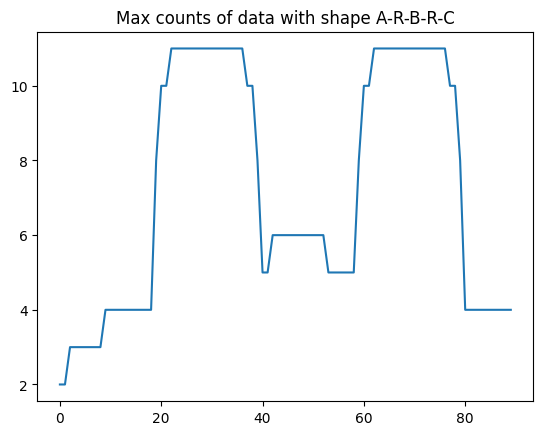

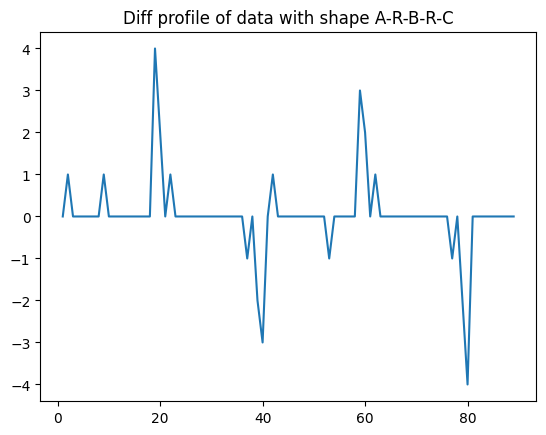

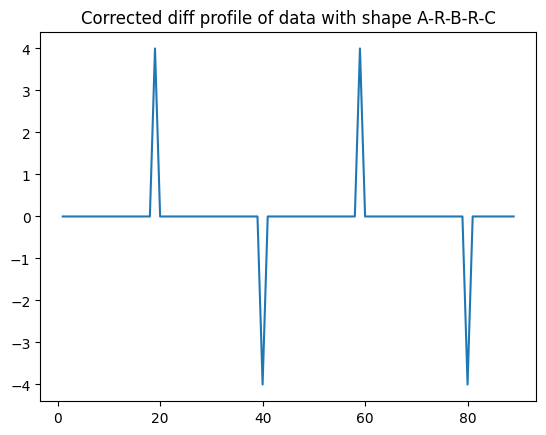

In [80]:
xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("data/circular-data.txt", "1111011011", 0)
print(se)
print(mci)
print(artifact)
# Plot
plt.plot([i for i in range(len(maxcounts))], maxcounts)
plt.title("Max counts of data with shape A-R-B-R-C")
plt.savefig('imgs/circular_dp.png', bbox_inches='tight')
plt.show()
# Plot
plt.plot(xpoints, pc_diff_profile)
plt.title("Diff profile of data with shape A-R-B-R-C")
plt.savefig('imgs/circular_dp.png', bbox_inches='tight')
plt.show()
# Plot
plt.plot(xpoints, ypoints)
plt.title("Corrected diff profile of data with shape A-R-B-R-C")
plt.savefig('imgs/circular_cdp.png', bbox_inches='tight')
plt.show()

Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
['a', 't', 'g', 'a', 'c']
1371
['a', 'g', 'g', 'a', 'a', 'c', 'a', 't', 'g', 'a', 'c', 'c']
['a', 't', 'g', 'a', 'c']
2185
['a', 't', 'c', 'g', 't', 'a', 'a', 't', 'g', 'a', 'c', 'c']
Not correct: 3


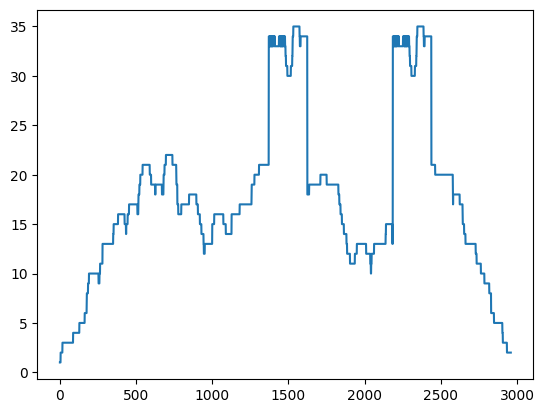

[1370, 1623, 2184, 2437]
[1374, 1624, 2188, 2438]


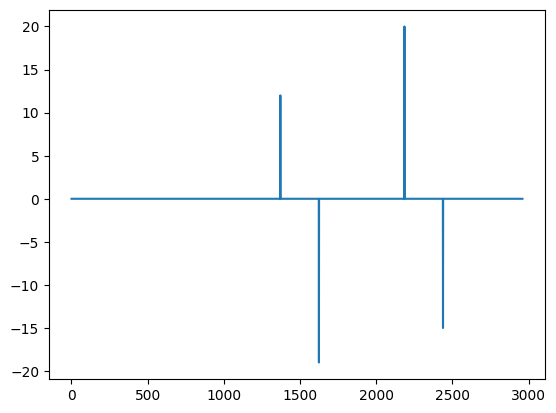

Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
['c', 'g', 'a', 't', 'a', 'c', 'g', 'a', 't', 't', 'a', 'a']
['g', 'a', 't', 't', 'a']
['c', 'g', 'a', 't', 'a', 'c', 'a', 'a', 'c', 'c', 'a', 'c']
['a', 'a', 'c', 'c', 'a']
Not correct: -4


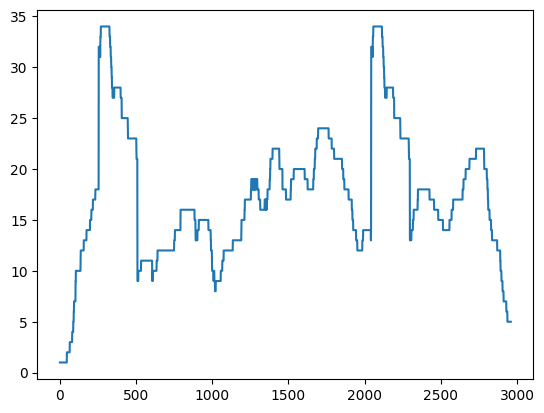

[254, 508, 2042, 2296]
[255, 505, 2043, 2293]


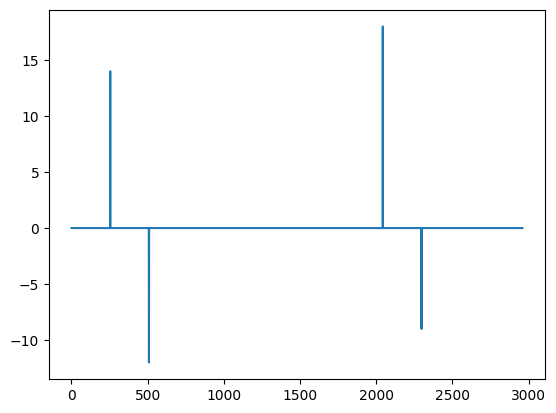

Correct!
Correct!
Correct!
Correct!
cov: 15
[]
---------


In [81]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
rounds = 50
minCov = 15
max_irregular_amplitudes = []
for _ in range(rounds):
    seq_copy = longseq.copy()
    R = random_seq()
    
    # pick random positions to insert the repetitions in.
    pos1 = np.random.randint(len(R),int(len(longseq)/2))
    pos2 = np.random.randint(int(len(longseq)/2)+len(R),len(longseq)-2*len(R))
    posis_to_compare_with = [pos1, pos1+len(R), pos2, pos2+len(R)]
    
    # insert repeats
    seq_with_reps = seq_copy[:pos1] + R + seq_copy[pos1+len(R):pos2] + R + seq_copy[pos2 + len(R):]
    
    # Now get reads from both strains
    reads = get_reads_from(seq_with_reps, read_len=250, coverage=minCov)

    # Add the full genomes to the read collection
    reads.insert(0, seq_with_reps)
    
    # Send it to the correction algorithm
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 0, data=reads)
    
    # get positions where repeats are detected
    posis_of_interest = [i for i in range(len(ypoints)) if np.abs(ypoints[i]) > 0]
    if len(posis_of_interest) > 4:
        print("More spikes")
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        print(posis_to_compare_with)
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        plt.plot(xpoints, ypoints)
        plt.show()
        continue
    elif len(posis_of_interest) < 4:
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        plt.plot(xpoints, ypoints)
        plt.show()
        print("less spikes")
        xpoints_solid, ypoints_solid, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "111111111111111111111111111111", 0, data=reads)
        plt.plot(xpoints, ypoints)
        plt.show()
        continue
    
    # Check if these positions correctly correspond to the repeat regions
    all_correct = True
    differences = 0
    diff_index = 0
    for i in range(len(posis_to_compare_with)):
        anticipated_posi = posis_to_compare_with[i]
        actual_posi = posis_of_interest[i]+1
        actual_pos_range = [i for i in range(actual_posi - 3, actual_posi + 3)]
        if not anticipated_posi in actual_pos_range:
            all_correct = False
            differences = anticipated_posi - actual_posi
            if differences > 0:
                posis_to_show = [seq_with_reps[i] for i in range(actual_posi - differences-3, anticipated_posi+3)]
                print(seq_with_reps[actual_posi:actual_posi+5])
                print(actual_posi)
                print(posis_to_show)
            else:
                print([seq_with_reps[i] for i in range(anticipated_posi-2, actual_posi - differences+2)])
                print(seq_with_reps[actual_posi:actual_posi+5])
            #print([seq_with_reps[anticipated_posi+i] for i in range(-5,5)])
            #print("correct! difference is " + str(anticipated_posi - actual_posi))
        #else:
            #print("wrong by: " + str(anticipated_posi - actual_posi))
    if all_correct: print("Correct!")
    else: 
        print("Not correct: " + str(differences))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        print(posis_to_compare_with)
        plt.plot(xpoints, ypoints)
        plt.show()

print("cov: " + str(minCov))
print(max_irregular_amplitudes)
print("---------")